# Access to solar wind IMF data

> Objective: Smoothed 1-minute time series of IMF, $B_{x,y,z}$ and solar wind speed, $v_{sw}$, including observations and (potentially) predictions

Solar wind / IMF are observed near L1 (currently by the ACE & DSCOVR spacecraft, but others in the past) and available from different US data sources (NASA/NOAA) at different levels of processing and latency:

1. Simplified merged data "OMNI" datasets service:
    - Merged from different spacecraft sources to make a long time series (ACE, WIND, IMP8, Geotail, (+ maybe DSCOVR?))
    - Includes time shifting of the series (variable ~10-60 minutes) to account for propagation of solar wind from L1 to Earth bow shock
    - This is the preferred source but comes with some (~months?) delay
    - Official sources:
        - NASA GSFC CDAWeb OMNIWeb (will this service continue?)  
          https://omniweb.gsfc.nasa.gov/html/ow_data.html  
          https://web.archive.org/web/20250730175513/https://omniweb.gsfc.nasa.gov/html/ow_data.html  
          - Also HAPI server:  
            https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/
        - NASA GSFC CCMC ISWA Web services (including HAPI):  
          https://ccmc.gsfc.nasa.gov/tools/ISWA/
1. Science data from missions (ACE is preferable)
    - ACE (NASA; mission at risk of cancellation)
        - NASA GSFC NSSDC: http://nssdc.gsfc.nasa.gov/nmc/spacecraftDisplay.do?id=1997-045A 
        - Caltech: https://izw1.caltech.edu/ACE/ASC/level2/index.html
    - DSCOVR (NOAA)
1. Near realtime data
    - NOAA services: https://www.swpc.noaa.gov/products-and-data

For input to geomagnetic models (e.g. AMPS), we need IMF `Bx, By, Bz` in GSM coordinates (note that BX_GSE = BX_GSM), and solar wind flow speed `v`:

> "The solar wind data that we use are time shifted to the bow shock nose, at 1-min time resolution (King & Papitashvili, 2005), and then averaged over the previous 20 min."

so we need the OMNI-style time shifting of 1-minute data, then apply a 20-minute averaging. Typically geomagnetic modellers are using OMNI as the data source.

```mermaid
flowchart LR
    sc(("Spacecraft:<br>(..older missions)<br>ACE<br>DSCOVR"))
    GSFC((NASA GSFC))
    OMNI["OMNI service<br>HRO / HRO2 ..."]
    cdaweb([GSFC CDAWeb])
    ccmc([GSFC CCMC])
    OMNI_out["OMNI (HRO2)<br>1-min time-shifted series<br>(1995 to ~a month ago)"]

    sc --> GSFC -->|Several s/c<br>Processing| OMNI --> cdaweb & ccmc
    cdaweb -->|CDAS WS<br>HAPI| OMNI_out
    ccmc -->|ISWA WS<br>HAPI| OMNI_out

    
    ACE_sources(["GSFC CDAWeb?<br>GSFC NSSDC<br>Caltech<br>SolarSoft"])
    ACE_data[ACE<br>Science data]
    GSFC -->|ACE data| ACE_sources --> ACE_data

    
    
    SWPC((NOAA SWPC))
    RTSW[RTSW<br>Realtime solar wind<br>service]
    RTSW_data["json files<br>(past 7 days)"]
    sc --> SWPC --> RTSW --> RTSW_data

    combined[Combined series]
    OMNI_out -->|Merge| combined
    ACE_data -->|?Merge?| combined
    RTSW_data -->|"<br>Time shift?<br>Merge"| combined
```

In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr
from hapiclient import hapi, hapitime2datetime
import matplotlib.pyplot as plt
from sunpy.coordinates import GeocentricSolarMagnetospheric, GeocentricSolarEcliptic
from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="hapiclient")

## Fetching data from HAPI (CDAWeb and CCMC ISWA)

In [3]:
def to_pandas(hapidata):
    df = pd.DataFrame(
        columns=hapidata.dtype.names,
        data=hapidata,
    ).set_index("Time")
    # Convert from hapitime to Python datetime and remove timezone awareness
    df.index = hapitime2datetime(df.index.values.astype(str))
    df.index = df.index.tz_convert("UTC").tz_convert(None)
    df.index.name = "Time"
    return df


def get_units_description(hapimeta):
    units = {}
    description = {}
    for paramdict in hapimeta["parameters"]:
        units[paramdict["name"]] = paramdict.get("units", None)
        description[paramdict["name"]] = paramdict.get("description", None)
    return units, description


def to_xarray(hapidata, hapimeta):
    ds = to_pandas(hapidata).to_xarray()
    units, description = get_units_description(hapimeta)
    for param in ds:
        ds[param].attrs = {"units": units[param], "description": description[param]}
    return ds


def fill2nan(hapidata, hapimeta):
    """Replace bad values (fill values given in metadata) with NaN"""
    hapidata = deepcopy(hapidata)
    for metavar in hapimeta["parameters"]:
        varname = metavar["name"]
        fillvalstr = metavar["fill"]
        if fillvalstr in (None, "null"):
            continue
        vardata = hapidata[varname]
        mask = vardata == float(fillvalstr)
        nbad = np.count_nonzero(mask)
        print("{}: {} fills NaN'd".format(varname, nbad))
        vardata[mask] = np.nan
    return hapidata, hapimeta


def fetch_cdaweb_omni(start, stop):
    # https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/
    server = "https://cdaweb.gsfc.nasa.gov/hapi"
    dataset = "OMNI_HRO2_1MIN"
    parameters = "BX_GSE,BY_GSM,BZ_GSM,flow_speed"
    data, meta = hapi(server, dataset, parameters, start, stop)
    data, meta = fill2nan(data, meta)
    return to_xarray(data, meta)


def fetch_iswa_swpc_rtsw_mag(start, stop):
    # https://ccmc.gsfc.nasa.gov/tools/ISWA/
    server = "https://iswa.gsfc.nasa.gov/IswaSystemWebApp/hapi"
    dataset = "swpc_rtsw_mag_P1M"
    parameters = "B_x,B_y,B_z,Latitude,Longitude"
    data, meta = hapi(server, dataset, parameters, start, stop)
    data, meta = fill2nan(data, meta)
    return to_xarray(data, meta)


def fetch_iswa_swpc_rtsw_plasma(start, stop):
    # https://ccmc.gsfc.nasa.gov/tools/ISWA/
    server = "https://iswa.gsfc.nasa.gov/IswaSystemWebApp/hapi"
    dataset = "swpc_rtsw_plasma_P1M"
    parameters = "BulkSpeed"
    data, meta = hapi(server, dataset, parameters, start, stop)
    data, meta = fill2nan(data, meta)
    return to_xarray(data, meta)

### OMNI via HAPI

OMNI HRO2 1MIN represents our "ideal" data. Data originates from multiple spacecraft depending on best availability (usually ACE). Data are processed to include propagation of the solar wind measurements at L1 to their arrival time at Earth's magnetosphere nose, and are definitive (they do not change).

In [4]:
ds_omni = fetch_cdaweb_omni("2025-09-01T00:00:00Z", "2026-01-21T00:00:00Z")
ds_omni

BX_GSE: 8815 fills NaN'd
BY_GSM: 8815 fills NaN'd
BZ_GSM: 8815 fills NaN'd
flow_speed: 54714 fills NaN'd


<xarray.Dataset> Size: 6MB
Dimensions:     (Time: 144066)
Coordinates:
  * Time        (Time) datetime64[ns] 1MB 2025-09-01 ... 2025-12-10T01:05:00
Data variables:
    BX_GSE      (Time) float64 1MB -0.61 -0.89 0.08 0.33 ... 6.03 6.03 6.09 6.18
    BY_GSM      (Time) float64 1MB -5.52 -5.62 -5.65 -5.74 ... -2.79 -1.98 -1.81
    BZ_GSM      (Time) float64 1MB 1.3 1.3 1.57 1.25 ... -2.05 -1.69 -2.48 -2.71
    flow_speed  (Time) float64 1MB nan nan nan 432.2 432.5 ... nan nan nan nan

Be aware that the real data availability interval may be shorter than that reported by the hapi server. The OMNI datasets are only updated periodically (in the example above, there is no data for over a month). So OMNI data are only suitable up to $t_{now}- N_{months}$ ($N$ is maybe 1-3?).

### SWPC RTSW via CCMC/ISWA HAPI

*NOAA* SWPC realtime solar wind data are available within a few minutes of measurement, but are of lower quality. The *NASA* ISWA service provides HAPI access to some of the SWPC data with a few extra minutes delay.

In [5]:
start = (dt.datetime.now() - dt.timedelta(days=1)).isoformat()
stop = dt.datetime.now().isoformat()
ds_rtsw = xr.merge(
    [fetch_iswa_swpc_rtsw_mag(start, stop), fetch_iswa_swpc_rtsw_plasma(start, stop)],
)
ds_rtsw

B_x: 0 fills NaN'd
B_y: 0 fills NaN'd
B_z: 0 fills NaN'd
BulkSpeed: 0 fills NaN'd


/tmp/ipykernel_148732/1743160781.py:3: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'Time' ('Time',) The recommendation is to set join explicitly for this case.
  ds_rtsw = xr.merge(


<xarray.Dataset> Size: 76kB
Dimensions:    (Time: 1362)
Coordinates:
  * Time       (Time) datetime64[ns] 11kB 2026-01-20T13:18:00 ... 2026-01-21T...
Data variables:
    B_x        (Time) float64 11kB -6.29 -6.16 -5.5 -5.79 ... -7.63 -7.5 nan
    B_y        (Time) float64 11kB 9.82 9.78 9.7 9.77 ... -0.44 -0.4 0.06 nan
    B_z        (Time) float64 11kB -7.91 -7.98 -8.65 -8.44 ... 1.5 1.34 1.54 nan
    Latitude   (Time) float64 11kB -34.17 -34.61 -37.8 -36.63 ... 9.97 11.63 nan
    Longitude  (Time) float64 11kB 122.6 122.2 119.6 120.7 ... 183.0 179.5 nan
    BulkSpeed  (Time) float64 11kB 896.7 912.6 894.0 841.1 ... 611.9 613.4 624.4

NB:
- To confirm coordinate system of `B_x, B_y, B_z`
- This does not include the time-shift that OMNI has included

## RTSW (realtime solar wind) from SWPC

This is the soonest available solar wind data, provided by NOAA as an operational space weather service. (ISWA is a few minutes delayed and does not provide all the parameters). Similarly to OMNI, they can originate from different spacecraft (mostly ACE). There are also "experimental" realtime data for ACE directly, available from NOAA.

More details available here:  
https://www.spaceweather.gov/products/real-time-solar-wind

Availability:
- in json for the past 7 days:  
  https://services.swpc.noaa.gov/products/solar-wind/
  - Ephemerides at 1-hour resolution:  
    https://services.swpc.noaa.gov/products/solar-wind/ephemerides.json
  - Magnetic data at 1-minute resolution:  
    https://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json
  - Plasma data at 1-minute resolution:  
    https://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json
- in json for the past 24 hours:  
  https://services.swpc.noaa.gov/json/rtsw/  
  https://services.swpc.noaa.gov/json/rtsw/rtsw_ephemerides_1h.json  
  https://services.swpc.noaa.gov/json/rtsw/rtsw_mag_1m.json  
  https://services.swpc.noaa.gov/json/rtsw/rtsw_wind_1m.json  
- in json **with time shifting applied**:  
  https://services.swpc.noaa.gov/products/geospace/  
  - past hour:  
    https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind-1-hour.json  
  - past 7 days:  
    https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind.json

*(Is it possible to get past ~3 months from SWPC? / whatever the maximum delay of OMNI release is)*

In [6]:
datasources_swpc = {
    "ephemerides": "https://services.swpc.noaa.gov/products/solar-wind/ephemerides.json",
    "mag-7-day": "https://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json",
    "plasma-7-day": "https://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json",
    "rtsw_ephemerides_1h": "https://services.swpc.noaa.gov/json/rtsw/rtsw_ephemerides_1h.json",
    "rtsw_mag_1m": "https://services.swpc.noaa.gov/json/rtsw/rtsw_mag_1m.json",
    "rtsw_wind_1m": "https://services.swpc.noaa.gov/json/rtsw/rtsw_wind_1m.json",
    "propagated-solar-wind-1-hour": "https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind-1-hour.json",
    "propagated-solar-wind": "https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind.json",
}

In [7]:
def fetch_json(url):
    df = pd.read_json(url)
    # wrangle format
    df.columns = df.iloc[0]
    df = df.drop(0)
    df = df.set_index("time_tag")
    df.index = pd.to_datetime(df.index)
    datavars = list(df.columns)
    timevar = "propagated_time_tag"
    datavars = [v for v in datavars if v != timevar]
    df[datavars] = df[datavars].astype(float)
    if timevar in df.columns:
        df[timevar] = pd.DatetimeIndex(df[timevar])
    return df

### SWPC propagated solar wind product

In [8]:
df_propagated_solar_wind = fetch_json(datasources_swpc["propagated-solar-wind"])
df_propagated_solar_wind

,speed,density,temperature,bx,by,bz,bt,vx,vy,vz,propagated_time_tag
time_tag,,,,,,,,,,,
2026-01-14 00:00:00,495.4,0.41,198975.0,4.82,-1.56,-1.15,5.19,NaN,NaN,NaN,2026-01-14 00:45:16
2026-01-14 00:01:00,497.7,0.43,206467.0,4.72,-1.66,-1.22,5.15,NaN,NaN,NaN,2026-01-14 00:46:03
2026-01-14 00:02:00,499.8,0.43,202826.0,4.74,-1.66,-1.32,5.20,NaN,NaN,NaN,2026-01-14 00:46:52
2026-01-14 00:03:00,500.9,0.43,202967.0,4.71,-1.66,-1.44,5.20,NaN,NaN,NaN,2026-01-14 00:47:46
2026-01-14 00:04:00,503.2,0.45,247341.0,4.64,-1.40,-1.77,5.16,NaN,NaN,NaN,2026-01-14 00:48:34
...,...,...,...,...,...,...,...,...,...,...,...
2026-01-21 13:09:00,619.7,1.12,55396.0,-7.56,-0.56,1.74,7.77,NaN,NaN,NaN,2026-01-21 13:45:01
2026-01-21 13:10:00,616.9,0.65,48672.0,-7.62,0.68,1.20,7.74,NaN,NaN,NaN,2026-01-21 13:46:11
2026-01-21 13:11:00,613.5,0.71,40850.0,-7.63,0.16,1.49,7.78,NaN,NaN,NaN,2026-01-21 13:47:23


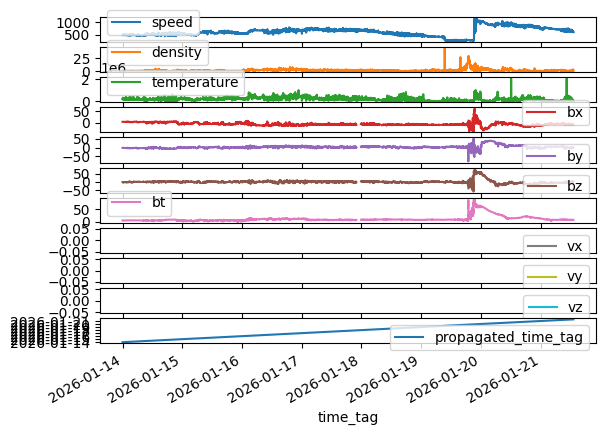

In [9]:
_ = df_propagated_solar_wind.plot(subplots=True)

- *What is the coordinate system of x,y,z? GSE or GSM?*
- *How do we reorder the time series to use the propagated time tag?*

### SWPC unpropagated products

In [10]:
df_ephemerides = fetch_json(datasources_swpc["ephemerides"])

In [11]:
df_ephemerides

,x_gse,y_gse,z_gse,vx_gse,vy_gse,vz_gse,x_gsm,y_gsm,z_gsm,vx_gsm,vy_gsm,vz_gsm
time_tag,,,,,,,,,,,,
2026-01-14 14:00:00,1549854.0,-12756.0,-70158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-14 15:00:00,1549854.0,-12756.0,-70158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-14 16:00:00,1549854.0,-12756.0,-70158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-14 17:00:00,1549854.0,-12756.0,-70158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-14 18:00:00,1549854.0,-12756.0,-70158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-16 20:00:00,1492452.0,-242364.0,-153072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-16 21:00:00,1492452.0,-242364.0,-153072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-16 22:00:00,1492452.0,-242364.0,-153072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


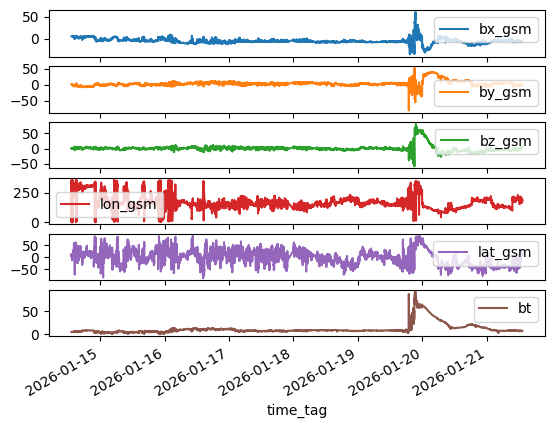

In [12]:
df_mag = fetch_json(datasources_swpc["mag-7-day"])
_ = df_mag.plot(subplots=True)

In [13]:
df_mag

,bx_gsm,by_gsm,bz_gsm,lon_gsm,lat_gsm,bt
time_tag,,,,,,
2026-01-14 13:18:00,5.10,0.85,0.71,9.41,7.81,5.22
2026-01-14 13:19:00,5.16,0.46,1.15,5.14,12.48,5.30
2026-01-14 13:20:00,5.25,0.42,0.99,4.54,10.70,5.36
2026-01-14 13:21:00,5.28,0.39,0.61,4.24,6.53,5.33
2026-01-14 13:22:00,5.40,0.28,0.02,2.94,0.24,5.41
...,...,...,...,...,...,...
2026-01-21 13:11:00,-7.63,0.16,1.49,178.79,11.01,7.78
2026-01-21 13:12:00,-7.65,-0.44,1.50,183.27,11.05,7.80
2026-01-21 13:13:00,-7.63,-0.40,1.34,183.02,9.97,7.75


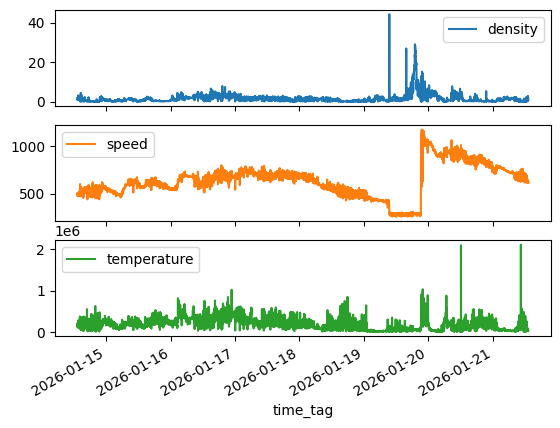

In [14]:
df_plasma = fetch_json(datasources_swpc["plasma-7-day"])
_ = df_plasma.plot(subplots=True)

#### Calculating time shift to apply

Time shift is dependent on spacecraft position and solar wind speed.

---

OMNI LRO (low resolution = 1 hour)

https://omniweb.gsfc.nasa.gov/html/ow_data.html#time_shift

https://web.archive.org/web/20250730175513/https://omniweb.gsfc.nasa.gov/html/ow_data.html#time_shift

```
Delta-t = (X/V) * {[1 + (Y*W)/X]/[1 - Ve*W/V]}, 
where 
Delta-t is the time shift in seconds, 
X and Y are GSE X and Y components of the spacecraft position vector, in km, 
V is the observed solar wind speed in km/s (assumed radial),
Ve is the speed of the Earth's orbital motion (30 km/s). 
W=tan [0.5 * atan (V/428)] is parameter related to the assumed orientation of the phase front relative
  to the Earth-sun line.  It is Half-way between corotation geometry and convection geometry.
```

---

OMNI/OMNI2 HRO (high resolution = 1 minute)

https://omniweb.gsfc.nasa.gov/html/HROdocum.html#3

King, J. H., and N. E. Papitashvili (2005), Solar wind spatial scales in and comparisons of hourly Wind and ACE plasma and magnetic field data, J. Geophys. Res., 110, A02104, [doi:10.1029/2004JA010649](https://doi.org/10.1029/2004JA010649). 

---

This description of time shifting is perhaps incomplete so I'm not sure what to do. For example on ["out of sequence arrivals"](https://omniweb.gsfc.nasa.gov/html/HROdocum.html#3c) the HRO approach is "to accept all shifted data as belonging to the newly assigned time tags that each record acquires via our simple time shift equation, and to build 1-min data products with averages over all points shifting into a given minute".

In [15]:
def calc_time_shift(df_ephemerides=df_ephemerides, df_plasma=df_plasma):
    df_ephemerides_1_minute = df_ephemerides.reindex(df_plasma.index).interpolate(
        method="linear"
    )
    X = df_ephemerides_1_minute["x_gse"].values  # in km
    Y = df_ephemerides_1_minute["y_gse"].values  # in km
    V = df_plasma["speed"].values  # in km/s
    Ve = 30
    W = np.tan(0.5 * np.arctan2(V, 428))
    delta_t = (X / V) * ((1 + (Y * W) / X) / (1 - Ve * W / V))
    return delta_t

Text(0, 0.5, 'time shift [minutes]')

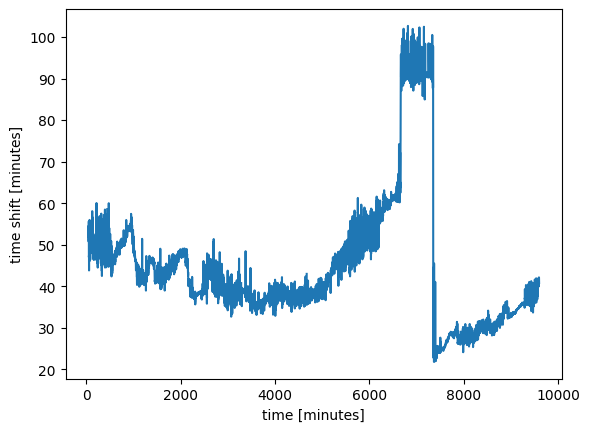

In [16]:
delta_t = calc_time_shift(df_ephemerides, df_plasma)
# NB Do something about the spikes
_ = plt.plot(delta_t / 60)
plt.xlabel("time [minutes]")
plt.ylabel("time shift [minutes]")

(compares somewhat well with the SWPC-provided propagations but is not quite the same, several minutes out)

## Use SWPC propagated data

Perhaps we can rely on the propagated data product and not do the propagation ourselves.

The propagated times are not monotic and can contain duplicates so this needs to be resolved. According to OMNI, we should "build 1-min data products with averages over all points shifting into a given minute", but what do we do with gaps?

In [17]:
df_propagated_solar_wind = fetch_json(datasources_swpc["propagated-solar-wind"])

In [18]:
df_propagated_solar_wind.index.is_monotonic_increasing

True

In [19]:
df_propagated_solar_wind["propagated_time_tag"].is_monotonic_increasing

False

In [20]:
def nanmean(series):
    """Compute the mean of a pandas Series, ignoring NaN values."""
    if series.isna().all() or len(series) == 0:
        return np.nan
    return series.mean(skipna=True)


# Reorganise time series with "propagated_time_tag" as the index
df = df_propagated_solar_wind.copy()
df = df.drop(columns=["density", "temperature", "bt", "vx", "vy", "vz"])
df = df.set_index("propagated_time_tag")
df = df.sort_index()
# df = df[~df.index.duplicated(keep="first")]
# Eliminated duplicates within the same minute, by averaging them
df = df.resample("min").agg(nanmean)
# Generate new UTC-minute-aligned index within the interval
t = df.index[0].to_pydatetime()
t_start = dt.datetime(t.year, t.month, t.day, t.hour, t.minute + 1, 0)
t = df.index[-1].to_pydatetime()
t_end = dt.datetime(t.year, t.month, t.day, t.hour, t.minute, 0)
utc_times = pd.date_range(t_start, t_end, freq="min")
new_index = utc_times.union(df.index).drop_duplicates()
# Interpolate original time series onto the UTC minutes
df = df.reindex(new_index).interpolate(method="linear")
df = df.reindex(utc_times)
df

,speed,bx,by,bz
2026-01-14 00:46:00,498.75,4.7300,-1.660,-1.2700
2026-01-14 00:47:00,500.90,4.7100,-1.660,-1.4400
2026-01-14 00:48:00,503.20,4.6400,-1.400,-1.7700
2026-01-14 00:49:00,508.70,4.5650,-1.390,-1.7450
2026-01-14 00:50:00,505.05,4.6325,-1.525,-1.6375
...,...,...,...,...
2026-01-21 13:45:00,619.70,-7.5600,-0.560,1.7400
2026-01-21 13:46:00,616.90,-7.6200,0.680,1.2000
2026-01-21 13:47:00,617.90,-7.6400,-0.140,1.4950
2026-01-21 13:48:00,614.90,-7.6350,-0.270,1.4175


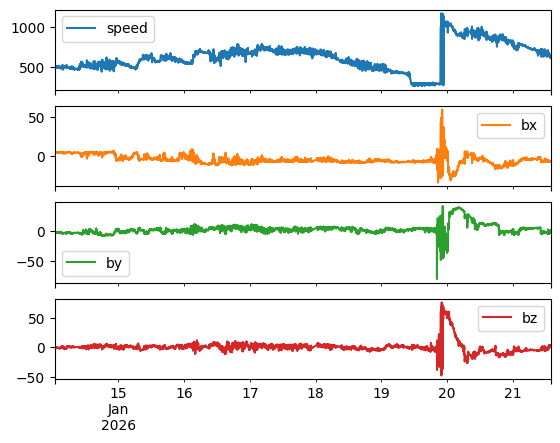

In [21]:
_ = df.plot(subplots=True)

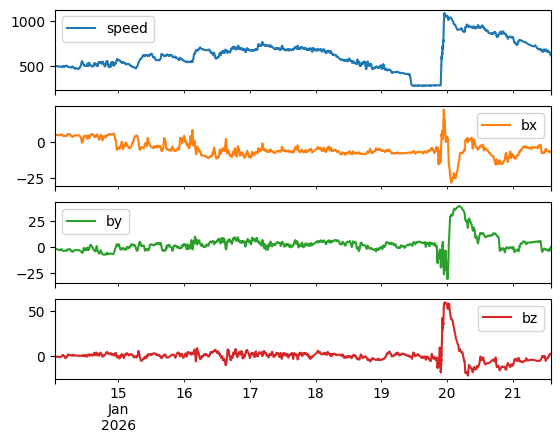

In [22]:
_ = df.rolling("20min").mean().plot(subplots=True)

## Notes

- TODO:
    - Confirm bx,by,bz are in GSM coordinates like OMNI / rotate if needed
    - Find if SWPC provide bulk download of past X months (not just past 7 days)
      - If not, we need to go to the ACE science data from e.g. Caltech? and do the propagation? and merge 3x series (OMNI, ACE science, RTSW)
      - or just wait a few weeks to gather the past data from RTSW time series
    - Verify / fix process of getting propagated timeseries
    - Check for fill values and possible spike removal
    - Investigate using only ACE data directly
    - Check how to merge the OMNI and rtsw safely
    - [ESA SWE](https://swe.ssa.esa.int) mirror the swpc rtsw (but not the propagated version). Might be available over their internal HAPI server (requires extra steps...)
    - Document exact procedure to create input for models (e.g. in Swarm handbook)
- Playing with marimo: https://marimo.app/l/vbw0oq